In [2]:
# This is the Analysis section of the project. This section will consist of 
# exploratory data analysis (EDA) and visualization of the datasets used in the project.
# These visualizations will help to understand the data and provide insights that may be useful for 
# future analysis and training of ML models.ipynb

# Sources:
# Disclaimer: GenAI was used for idea generation, suggestions, and debugging but not for full code generation.

In [3]:
# Imports
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skbio.diversity.alpha import shannon, simpson
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier


In [4]:
# Import datasets with pandas
filepath = os.getcwd() + "/datasets"
dataset_4_1 = pd.read_csv(os.path.join(filepath, "4.1_final_assignments.csv"))
dataset_4_2 = pd.read_csv(os.path.join(filepath, "4.2_final_assignments.csv"))
dataset_4_3 = pd.read_csv(os.path.join(filepath, "4.3_final_assignments.csv"))
dataset_4_4 = pd.read_csv(os.path.join(filepath, "4.4_final_assignments.csv"))
dataset_4_5 = pd.read_csv(os.path.join(filepath, "4.5_final_assignments.csv"))
dataset_8_1 = pd.read_csv(os.path.join(filepath, "8.1_final_assignments.csv"))
dataset_8_2 = pd.read_csv(os.path.join(filepath, "8.2_final_assignments.csv"))
dataset_8_3 = pd.read_csv(os.path.join(filepath, "8.3_final_assignments.csv"))
dataset_8_4 = pd.read_csv(os.path.join(filepath, "8.4_final_assignments.csv"))
dataset_8_5 = pd.read_csv(os.path.join(filepath, "8.5_final_assignments.csv"))

In [5]:
# Combine Datasets into one set for visualization and analysis
combined_dataset = pd.concat([dataset_4_1, dataset_4_2, dataset_4_3, dataset_4_4, dataset_4_5, dataset_8_1, 
                              dataset_8_2, dataset_8_3, dataset_8_4, dataset_8_5], ignore_index=True)

# Drop any fully duplicated rows
combined_dataset.drop_duplicates(inplace=True)

# Drop rows where critical values are missing (essentially dropNA on key columns)
critical_cols = ['wwtp', 'wrf', 'GenomeName', 'Proteins', 'network']
combined_dataset.dropna(subset=critical_cols, inplace=True)

# Convert time and pore size collumns to appropriate data types
combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
combined_dataset['pore.size.um'] = combined_dataset['pore.size'].str.extract(r'(\d+\.?\d*)').astype(float)
combined_dataset.drop('pore.size', axis=1, inplace=True)


# Standardize string columns and clean prediction columns
object_cols = combined_dataset.select_dtypes(include='object').columns.tolist()

for col in object_cols:
    combined_dataset[col] = combined_dataset[col].astype(str).str.lower()
    
    # Clean predictions (e.x 'taleaviricota|nan' -> 'taleaviricota')
    if 'prediction' in col:
        # Split by '|' and take the first element (the most likely prediction)
        combined_dataset[col] = combined_dataset[col].str.split('|').str[0]

# Fill nan Genome Size (Kb) with the median
median_size = combined_dataset['Size (Kb)'].median()
combined_dataset['Size (Kb)'].fillna(median_size, inplace=True)

# Fill remaining NaN values in object columns with 'unknown'
object_cols_for_filling = combined_dataset.select_dtypes(include='object').columns.tolist()
for col in object_cols_for_filling:
    combined_dataset[col].fillna('unknown', inplace=True)

# Generate CSV of combined dataset for future use
combined_dataset.to_csv(os.path.join(filepath, "combined_final_assignments.csv"), index=False)

/var/folders/4m/g79cc05d4jg252d8xkyzdbfr0000gn/T/ipykernel_51028/2739461662.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
/var/folders/4m/g79cc05d4jg252d8xkyzdbfr0000gn/T/ipykernel_51028/2739461662.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
/var/folders/4m/g79cc05d4jg252d8xkyzdbfr0000gn/T/ipykernel_51028/2739461662.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

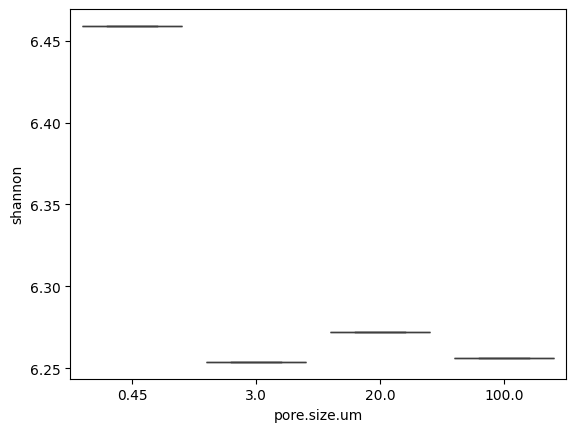

<Figure size 1200x800 with 0 Axes>

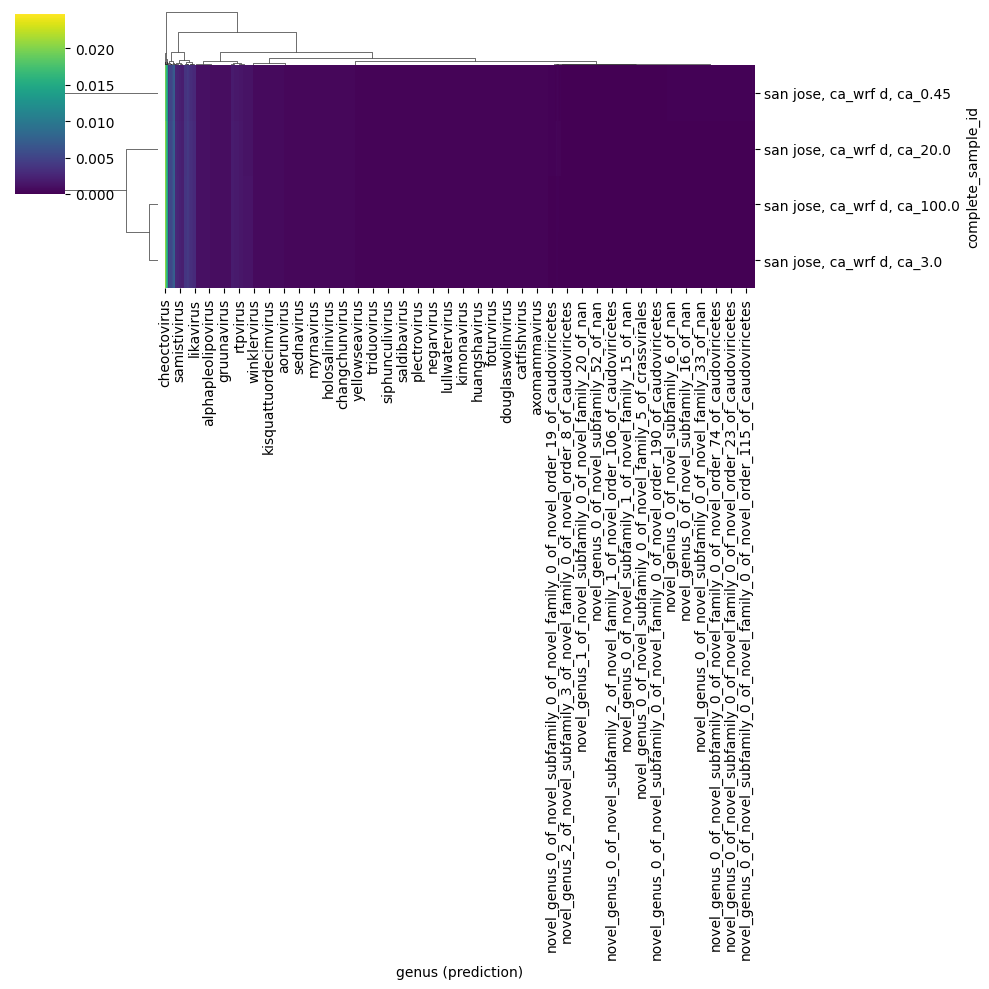

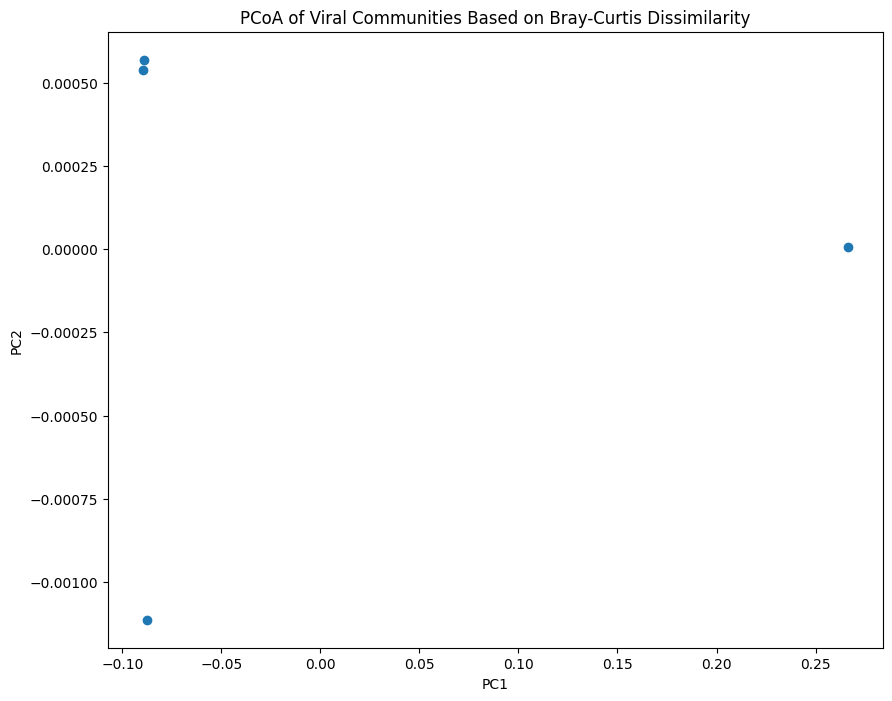

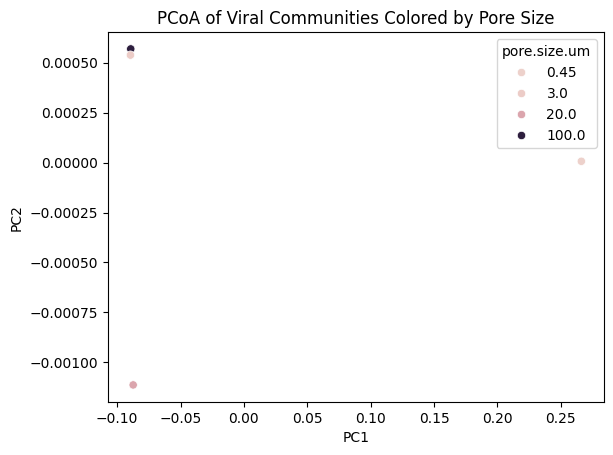

In [6]:
### Part 1 #################################################################################################################
# Notes left for clarity. This section is essentially guided EDA and visualization of viral diversity accross pore sizes
# for part 1 of our project tasking

# Viral Density Accross Pore Sizes 
df = pd.read_csv("datasets/combined_final_assignments.csv")

# Create individual sample identifiers
df['complete_sample_id'] = (
    df['wwtp'] + "_" +
    df['wrf'] + "_" +
    df['pore.size.um'].astype(str)
)

# Create a genus abundance table
genus_table = (
    df.groupby(['complete_sample_id', 'genus (prediction)'])
      .size()
      .reset_index(name='abundance')
      .pivot(index='complete_sample_id', columns='genus (prediction)', values='abundance')
      .fillna(0)
)


# evaluate the diversity by metrics such as alpha diversity and beta diversity, PCoA clusters, heatmaps (From our assignmetn instructions)
# Alpha diversity is calculated using Shannon index, Simpson index, and richness (the number of unique genera)
# calc alpha diversity metrics
alpha_df = pd.DataFrame({
    'sample_id': genus_table.index,
    'shannon': genus_table.apply(shannon, axis=1),
    'simpson': genus_table.apply(simpson, axis=1),
    'richness': (genus_table > 0).sum(axis=1)
})

# merge metadata back into alpha diversity dataframe
alpha_df = alpha_df.merge(
    df[['complete_sample_id', 'pore.size.um', 'wwtp', 'wrf']].drop_duplicates(),
    on='complete_sample_id',
    how='left'
)

# Plot Shannon Diversity relating to pore sizes
sns.boxplot(data=alpha_df, x='pore.size.um', y='shannon')
plt.show()

# Headmap of genus abundance
plt.figure(figsize=(12,8))
sns.clustermap(genus_table.apply(lambda x: x / x.sum(), axis=1),
               cmap='viridis',
               metric='euclidean',
               method='ward')
plt.show()

# Beta Diversity
# Beta diversity is a measure of the difference in diversity between samples. Uses Bray-Curtis dissimilarity 
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
bray_curtis_dm = beta_diversity(
    metric='braycurtis',
    counts=genus_table.values,
    ids=genus_table.index
)
pcoa_results = pcoa(bray_curtis_dm)

# Plot PCoA results
plt.figure(figsize=(10,8))
plt.scatter(pcoa_results.samples['PC1'], pcoa_results.samples['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCoA of Viral Communities Based on Bray-Curtis Dissimilarity')
plt.show()

# PCoA Clusters
sns.scatterplot(
    data=pcoa_results.samples,
    x='PC1',
    y='PC2',
    hue=alpha_df.set_index('complete_sample_id').loc[pcoa_results.samples.index]['pore.size.um']
)
plt.title('PCoA of Viral Communities Colored by Pore Size')
plt.show()

In [8]:
# Application of ML methods to predict viral taxonomy from genome level features 

features = df[['Size (Kb)', 'Proteins', 'pore.size.um', 'wwtp', 'wrf', 'season', 'network']]
target_family = df['family (prediction)']
target_genus  = df['genus (prediction)']

# remove rows where the target is missing
valid_idx = target_family.notna()
features = features.loc[valid_idx]
target_family = target_family.loc[valid_idx]
target_genus = target_genus.loc[valid_idx]

## Replace any newly introduce NAN values from one-hot encoding
# Fill NaN values in categorical features with 'unknown' (One-hot encoding can not handle NaN values)
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# fill missing numerical values with median
features['Size (Kb)'] = features['Size (Kb)'].fillna(features['Size (Kb)'].median())
features['Proteins'] = features['Proteins'].fillna(features['Proteins'].median())
features['pore.size.um'] = features['pore.size.um'].fillna(features['pore.size.um'].median())

# fill missing categorical values with 'unknown'
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# use one-hot encoding for catagorical variables
# one-hot encoding converts categorial vars into elements of 0s and 1s for ML processing
X = pd.get_dummies(features, drop_first=True)
y_family = target_family
y_genus = target_genus

# final NaN replacement for safety
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
y_family = y_family.fillna("unknown")
y_genus = y_genus.fillna("unknown")

# count how many times each class appears and drop all with less than 2 (causes issues with training/test split)
counts = y_family.value_counts()
valid_classes = counts[counts >= 2].index
mask = y_family.isin(valid_classes)
X = X[mask]
y_family = y_family[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_family, test_size=0.2, stratify=y_family, random_state=42
)

# Random Forest classifier for family prediction
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))


# Neural Network classifier for family prediction (uses MLP)
# MLP is a feedforward model that maps input data onto appropriate outputs
mlp = MLPClassifier(hidden_layer_sizes=(128,64),
                    activation='relu',
                    max_iter=500)

mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, pred_mlp))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                                                     precision    recall  f1-score   support

                                   ackermannviridae       0.94      0.98      0.96       132
                                     aggregaviridae       1.00      1.00      1.00         2
                                  aliceevansviridae       0.94      0.96      0.95       316
                                    anaerodiviridae       1.00      1.00      1.00         2
                                    arenbergviridae       1.00      1.00      1.00         2
                                      assiduviridae       0.75      1.00      0.86         6
                                  autographiviridae       0.98      0.98      0.98       729
                                    autolykiviridae       1.00      1.00      1.00        10
                                     bicaudaviridae       1.00      0.75      0.86        16
                                     casjensviridae       1.00      1

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  